In [1]:
import bagpy
from tqdm import tqdm
from typing import *
from shapely.geometry import *
from os.path import join, exists
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import geopandas as gpd

In [2]:
worlds_df = pd.read_pickle("/home/agusmazzeo/Documents/UTN/Proyecto/worlds_df.pkl")

In [101]:
worlds_df.index

Index(['evaluation_7', 'evaluation_1', 'evaluation_5', 'evaluation_0',
       'evaluation_9', 'evaluation_6', 'evaluation_3', 'evaluation_2',
       'evaluation_8', 'evaluation_10',
       ...
       'evaluation_186', 'evaluation_190', 'evaluation_191', 'evaluation_192',
       'evaluation_193', 'evaluation_194', 'evaluation_195', 'evaluation_196',
       'evaluation_197', 'evaluation_198'],
      dtype='object', length=163)

In [32]:
class BagpyDataHandler:
    
    def __init__(self, worlds_df: pd.DataFrame, outputs_dir: str):
        self.res_values = {}
        self.report = {}
        self.worlds = {}
        cont = 0
        for index in tqdm(worlds_df[worlds_df["finished_true"]].index):
            try:
                cont+=1
                # if cont == 10:
                #     break
                result = self.get_results_from_folder(join(outputs_dir, index))
                if result is not None:
                    self.res_values[index] = result
                    self.worlds[index] = worlds_df.loc[index]
                    self.report[index] = self.get_report_data(index, result)
            except Exception:
                continue
        reform = {(outerKey, innerKey): values for outerKey, innerDict in self.report.items() for innerKey, values in innerDict.items()}
        self.report_df = pd.DataFrame(reform)
                
    def get_report_data(self, index: str, result: Dict[str, Any]):
        report = {}
        world_polygon = self.worlds[index].world.free_space_polygon
        if isinstance(world_polygon, MultiPolygon):
            world_polygon = world_polygon.convex_hull
        for key in result.keys():
            if key not in report.keys():
                report[key] = {}
            poly = gpd.GeoDataFrame(geometry=[world_polygon.exterior])
            report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
        return report
    
    def get_exploration_data(self, key: str, index: str, result: Dict[str, Any]):
        free_area = self.worlds[index]["free_area"]
        explored_per_distance = pd.merge_asof(result[key]["explored_df"], result[key]["travelled_distance_df"], on="timestamp")
        explored_area = explored_per_distance["m_2_explored"].iloc[-1]
        exploration = {
            "explored_percentage": 100*explored_area/free_area,
            "total_time_sec": explored_per_distance.index[-1],
            "dist_explored_20%": explored_per_distance.loc[explored_per_distance["m_2_explored"]<(20*free_area/100)].iloc[-1]["cum_distance"],
            "dist_explored_50%": explored_per_distance.loc[explored_per_distance["m_2_explored"]<(50*free_area/100)].iloc[-1]["cum_distance"],
            "dist_explored_80%": explored_per_distance.loc[explored_per_distance["m_2_explored"]<(80*free_area/100)].iloc[-1]["cum_distance"],
            "dist_total": explored_per_distance.iloc[-1]["cum_distance"],
        }
        return exploration
            
    def get_results_from_folder(self, folder: str) -> Dict[str, Tuple[List[float], List[float]]]:
        try:
            utn_path = join(folder, "UTN")
            utn_dist_path = join(folder, "UTN_CON_DISTANCIA")
            maryland_path = join(folder, "MARYLAND")
            if not exists(utn_path) or not exists(maryland_path) or not exists(utn_dist_path):
                # print(f"Skipping {folder} because of not having both maryland and UTN")
                return None
            utn_bag_file = glob(join(utn_path, "*.bag"))[0]
            utn_dist_bag_file = glob(join(utn_dist_path, "*.bag"))[0]
            maryland_bag_file = glob(join(maryland_path, "*.bag"))[0]
            reader_utn = bagpy.bagreader(utn_bag_file)
            reader_utn_dist = bagpy.bagreader(utn_dist_bag_file)
            reader_maryland = bagpy.bagreader(maryland_bag_file)
            res = {
                "UTN": self.get_times_and_explores(reader_utn),
                "UTN_DIST": self.get_times_and_explores(reader_utn_dist),
                "MARYLAND": self.get_times_and_explores(reader_maryland)}
            return res
        except Exception as ex:
            print(f"An error ocurred on {folder}: {ex}")
            return None
    
    @staticmethod
    def get_explored_df(reader: bagpy.bagreader) -> pd.DataFrame:
        explored_data =  reader.reader.read_messages("/create1/explored")
        amt_of_non_unknown = []
        timestamps = []
        for d in explored_data:
            amt_of_non_unknown.append(d.message.data)
            timestamps.append(d.timestamp.to_sec())
        amt_of_non_unknown = [0.0025 * item for item in amt_of_non_unknown]
        dic = {"timestamp": timestamps, "m_2_explored": amt_of_non_unknown}
        df = pd.DataFrame(dic)
        df["timestamp"] -= dic["timestamp"][0]
        df = df.set_index("timestamp")
        return df

    @staticmethod
    def get_travelled_distance_df(reader: bagpy.bagreader) -> pd.DataFrame:
        travelled_data =  reader.reader.read_messages("/create1/travelled_distance")
        cum_distance = []
        timestamps = []
        for d in travelled_data:
            cum_distance.append(d.message.data)
            timestamps.append(d.timestamp.to_sec())
        dic = {"timestamp": timestamps, "cum_distance": cum_distance}
        df = pd.DataFrame(dic)
        df["timestamp"] -= dic["timestamp"][0]
        df = df.set_index("timestamp")
        return df

    @staticmethod
    def get_trajectory_df(reader: bagpy.bagreader) -> gpd.GeoDataFrame:
        gts =  reader.reader.read_messages("/create1/gts")
        xs = []
        ys = []
        timestamps = []
        for d in gts:
            xs.append(d.message.pose.pose.position.x)
            ys.append(d.message.pose.pose.position.y)
            timestamps.append(d.timestamp.to_sec())
        dic = {"timestamp": timestamps, "x": xs, "y": ys}
        df = pd.DataFrame(dic)
        df["timestamp"] -= dic["timestamp"][0]
        df = df.set_index("timestamp")
        return gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y))

    def get_times_and_explores(self, reader: bagpy.bagreader) -> Tuple[List[float], List[float]]:
        explored_df = self.get_explored_df(reader)
        travelled_distance_df = self.get_travelled_distance_df(reader)
        trajectory_df = self.get_trajectory_df(reader)
        return {"explored_df": explored_df, "travelled_distance_df":travelled_distance_df, "trajectory_df":trajectory_df}

    def plot_exp_by_dist(self, index: str):
        res = self.res_values[index]
        utn_df=  pd.merge_asof(res["UTN"]["explored_df"], res["UTN"]["travelled_distance_df"], on="timestamp")
        utn_dist_df = pd.merge_asof(res["UTN_DIST"]["explored_df"], res["UTN_DIST"]["travelled_distance_df"], on="timestamp")
        maryland_df=  pd.merge_asof(res["MARYLAND"]["explored_df"], res["MARYLAND"]["travelled_distance_df"], on="timestamp")
        utn_df = utn_df.dropna()
        utn_dist_df = utn_dist_df.dropna()
        maryland_df = maryland_df.dropna()

        plt.plot( utn_df["timestamp"], utn_df["m_2_explored"], label="UTN")
        plt.plot( utn_dist_df["timestamp"], utn_dist_df["m_2_explored"], label="UTN_DIST")
        plt.plot( maryland_df["timestamp"], maryland_df["m_2_explored"], label="MARYLAND")
        plt.ylabel("Explored area [m2]")
        plt.xlabel("Distance travelled [m]")

        plt.legend()
        
    def plot_exp_percentage_by_dist(self, index: str):
        total_area = self.worlds[index].loc['world'].total_area
        res = self.res_values[index]
        utn_df=  pd.merge_asof(res["UTN"]["explored_df"], res["UTN"]["travelled_distance_df"], on="timestamp")
        utn_dist_df = pd.merge_asof(res["UTN_DIST"]["explored_df"], res["UTN_DIST"]["travelled_distance_df"], on="timestamp")
        maryland_df=  pd.merge_asof(res["MARYLAND"]["explored_df"], res["MARYLAND"]["travelled_distance_df"], on="timestamp")
        utn_df = utn_df.dropna()
        utn_dist_df = utn_dist_df.dropna()
        maryland_df = maryland_df.dropna()

        plt.plot( utn_df["cum_distance"], 100*utn_df["m_2_explored"]/total_area, label="UTN")
        plt.plot( utn_dist_df["cum_distance"], 100*utn_dist_df["m_2_explored"]/total_area, label="UTN_DIST")
        plt.plot( maryland_df["cum_distance"], 100*maryland_df["m_2_explored"]/total_area, label="MARYLAND")
        plt.ylabel("Explored area [%]")
        plt.xlabel("Distance travelled [m]")

        plt.legend()
    
    def plot_trajectory(self, index: str):
        report = self.report[index]
        report["UTN"]["trajectory"].buffer(0.2).plot()
        report["UTN_DIST"]["trajectory"].buffer(0.2).plot()
        report["MARYLAND"]["trajectory"].buffer(0.2).plot()
        

In [33]:
BASE_DIR = "/home/agusmazzeo/Documents/UTN/Proyecto/outputs_2"

In [34]:
bdh = BagpyDataHandler(worlds_df, BASE_DIR) 

  0%|                                                                                                                    | 0/77 [00:00<?, ?it/s]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_1/UTN/exploration_data_2022-10-26-12-47-03 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_1/UTN_CON_DISTANCIA/exploration_data_2022-11-08-05-56-54 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_1/MARYLAND/exploration_data_2022-10-26-12-47-02 already exists. Not creating.


/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
  3%|██▊                                                                                                         | 2/7

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_5/UTN/exploration_data_2022-10-26-12-47-03 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_5/UTN_CON_DISTANCIA/exploration_data_2022-11-08-05-56-53.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_5/MARYLAND/exploration_data_2022-10-26-12-47-03 already exists. Not creating.


/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
  4%|████▏                                                                                                       | 3/7

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_0/UTN/exploration_data_2022-10-26-13-13-06.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_0/UTN_CON_DISTANCIA/exploration_data_2022-11-08-05-57-01 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_0/MARYLAND/exploration_data_2022-10-26-13-07-41.orig already exists. Not creating.


/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
  5%|█████▌                                                                                                      | 4/7

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_9/UTN/exploration_data_2022-10-26-13-31-21.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_9/UTN_CON_DISTANCIA/exploration_data_2022-11-08-06-50-05.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_9/MARYLAND/exploration_data_2022-10-26-13-14-26.orig already exists. Not creating.


/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
  6%|███████                                                                                                     | 5/7

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_6/UTN/exploration_data_2022-10-26-13-46-33 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_6/UTN_CON_DISTANCIA/exploration_data_2022-11-08-06-50-05.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_6/MARYLAND/exploration_data_2022-10-26-13-31-39.orig already exists. Not creating.


/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
  8%|████████▍                                                                                                   | 6/7

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_3/UTN/exploration_data_2022-10-26-13-59-18.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_3/UTN_CON_DISTANCIA/exploration_data_2022-11-08-06-50-05.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_3/MARYLAND/exploration_data_2022-10-26-13-47-11.orig already exists. Not creating.


/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
  9%|█████████▊                                                                                                  | 7/7

An error ocurred on /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_2: list index out of range
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_8/UTN/exploration_data_2022-10-26-14-27-24 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_8/UTN_CON_DISTANCIA/exploration_data_2022-11-08-07-07-22 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_8/MARYLAND/exploration_data_2022-10-26-14-26-27 already exists. Not creating.


/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 12%|████████████▌                                                                                               | 9/7

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_10/UTN/exploration_data_2022-10-26-14-46-41.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_10/UTN_CON_DISTANCIA/exploration_data_2022-11-08-07-16-03 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_10/MARYLAND/exploration_data_2022-10-26-14-38-17 already exists. Not creating.


/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 13%|█████████████▉                                                                                             | 10/7

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_12/UTN/exploration_data_2022-10-26-15-10-29.orig already exists. Not creating.
[INFO]  Successfully created the data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_12/UTN_CON_DISTANCIA/exploration_data_2022-11-08-07-21-09.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_12/MARYLAND/exploration_data_2022-10-26-14-50-01 already exists. Not creating.


/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 14%|███████████████▎                                                                                           | 11/7

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_19/UTN/exploration_data_2022-10-26-15-13-20 already exists. Not creating.
[INFO]  Successfully created the data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_19/UTN_CON_DISTANCIA/exploration_data_2022-11-08-07-26-29.orig.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_19/MARYLAND/exploration_data_2022-10-26-15-11-43 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_16/UTN/exploration_data_2022-10-26-15-17-22 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_16/UTN_CON_DISTANCIA/exploration_data_2022-11-08-07-28-07 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_16/MARYLAND/exploration_data_2022-10-26-15-15-01 already exists. Not creating.


/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 17%|██████████████████                                                                                         | 13/7

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_11/UTN/exploration_data_2022-10-26-15-42-37.orig already exists. Not creating.
[INFO]  Successfully created the data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_11/UTN_CON_DISTANCIA/exploration_data_2022-11-08-07-30-14.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_11/MARYLAND/exploration_data_2022-10-26-15-38-14 already exists. Not creating.


/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 18%|███████████████████▍                                                                                       | 14/7

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_14/UTN/exploration_data_2022-10-26-15-52-20 already exists. Not creating.
[INFO]  Successfully created the data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_14/UTN_CON_DISTANCIA/exploration_data_2022-11-08-07-48-38.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_14/MARYLAND/exploration_data_2022-10-26-15-44-24 already exists. Not creating.


/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 19%|████████████████████▊                                                                                      | 15/7

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_18/UTN/exploration_data_2022-10-26-16-07-38.orig already exists. Not creating.
[INFO]  Successfully created the data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_18/UTN_CON_DISTANCIA/exploration_data_2022-11-08-08-01-02.orig.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_18/MARYLAND/exploration_data_2022-10-26-16-01-14.orig already exists. Not creating.


/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 21%|██████████████████████▏                                                                                    | 16/7

[INFO]  Successfully created the data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_17/UTN/exploration_data_2022-10-26-16-28-15.
[INFO]  Successfully created the data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_17/UTN_CON_DISTANCIA/exploration_data_2022-11-08-08-03-04.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_17/MARYLAND/exploration_data_2022-10-26-16-15-36 already exists. Not creating.


/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 22%|███████████████████████▌                                                                                   | 17/7

[INFO]  Successfully created the data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_21/UTN/exploration_data_2022-10-26-16-38-05.
[INFO]  Successfully created the data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_21/UTN_CON_DISTANCIA/exploration_data_2022-11-08-08-08-15.orig.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_21/MARYLAND/exploration_data_2022-10-26-16-32-28 already exists. Not creating.


/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 23%|█████████████████████████                                                                                  | 18/7

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_23/UTN/exploration_data_2022-10-26-17-00-03.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_23/UTN_CON_DISTANCIA/exploration_data_2022-11-08-08-10-58 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_23/MARYLAND/exploration_data_2022-10-26-16-58-02.orig already exists. Not creating.


/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 25%|██████████████████████████▍                                                                                | 19/7

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_25/UTN/exploration_data_2022-10-26-17-12-44.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_25/UTN_CON_DISTANCIA/exploration_data_2022-11-08-08-29-27 already exists. Not creating.
[INFO]  Successfully created the data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_25/MARYLAND/exploration_data_2022-10-26-17-05-34.


/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 26%|███████████████████████████▊                                                                               | 20/7

[INFO]  Successfully created the data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_22/UTN/exploration_data_2022-10-26-17-54-35.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_22/UTN_CON_DISTANCIA/exploration_data_2022-11-08-08-30-01.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_22/MARYLAND/exploration_data_2022-10-26-17-32-37.orig already exists. Not creating.


/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 27%|█████████████████████████████▏                                                                             | 21/7

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_27/UTN/exploration_data_2022-10-26-18-05-50.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_27/UTN_CON_DISTANCIA/exploration_data_2022-11-08-08-41-49 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_27/MARYLAND/exploration_data_2022-10-26-18-00-15 already exists. Not creating.


/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 29%|██████████████████████████████▌                                                                            | 22/7

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_26/UTN/exploration_data_2022-10-26-18-24-46 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_26/UTN_CON_DISTANCIA/exploration_data_2022-11-08-08-53-57 already exists. Not creating.
[INFO]  Successfully created the data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_26/MARYLAND/exploration_data_2022-10-26-18-13-00.orig.


/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 30%|███████████████████████████████▉                                                                           | 23/77 [01:29<04:13,  4.70s/it]

[INFO]  Successfully created the data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_29/UTN/exploration_data_2022-10-26-18-32-08.orig.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_29/UTN_CON_DISTANCIA/exploration_data_2022-11-08-08-59-36.orig already exists. Not creating.
[INFO]  Successfully created the data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_29/MARYLAND/exploration_data_2022-10-26-18-29-21.orig.


/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 31%|█████████████████████████████████▎                                                                         | 24/7

[INFO]  Successfully created the data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_32/UTN/exploration_data_2022-10-26-18-58-41.orig.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_32/UTN_CON_DISTANCIA/exploration_data_2022-11-08-09-08-27 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_32/MARYLAND/exploration_data_2022-10-26-18-54-05 already exists. Not creating.


/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 32%|██████████████████████████████████▋                                                                        | 25/7

[INFO]  Successfully created the data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_31/UTN/exploration_data_2022-10-26-19-09-11.orig.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_31/UTN_CON_DISTANCIA/exploration_data_2022-11-08-09-12-47 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_31/MARYLAND/exploration_data_2022-10-26-19-06-02.orig already exists. Not creating.


/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 34%|████████████████████████████████████▏                                                                      | 26/7

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_30/UTN/exploration_data_2022-10-26-19-31-26.orig already exists. Not creating.
[INFO]  Successfully created the data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_30/UTN_CON_DISTANCIA/exploration_data_2022-11-08-09-29-38.orig.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_30/MARYLAND/exploration_data_2022-10-26-19-14-50.orig already exists. Not creating.


/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 35%|█████████████████████████████████████▌                                                                     | 27/7

[INFO]  Successfully created the data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_35/UTN/exploration_data_2022-10-26-19-58-29.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_35/UTN_CON_DISTANCIA/exploration_data_2022-11-08-09-32-35.orig already exists. Not creating.
[INFO]  Successfully created the data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_35/MARYLAND/exploration_data_2022-10-26-19-36-38.orig.


/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 36%|██████████████████████████████████████▉                                                                    | 28/7

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_34/UTN/exploration_data_2022-10-26-20-09-22.orig already exists. Not creating.
[INFO]  Successfully created the data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_34/UTN_CON_DISTANCIA/exploration_data_2022-11-08-09-34-38.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_34/MARYLAND/exploration_data_2022-10-26-20-06-14.orig already exists. Not creating.


/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 38%|████████████████████████████████████████▎                                                                  | 29/7

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_33/UTN/exploration_data_2022-10-26-20-34-47.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_33/UTN_CON_DISTANCIA/exploration_data_2022-11-08-09-55-25 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_33/MARYLAND/exploration_data_2022-10-26-20-10-11 already exists. Not creating.


/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 39%|█████████████████████████████████████████▋                                                                 | 30/7

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_39/UTN/exploration_data_2022-10-26-20-42-48.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_39/UTN_CON_DISTANCIA/exploration_data_2022-11-08-10-02-52 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_39/MARYLAND/exploration_data_2022-10-26-20-35-53 already exists. Not creating.


/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_3540/2515814446.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/7

An error ocurred on /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_36: list index out of range
An error ocurred on /home/agusmazzeo/Documents/UTN/Proyecto/outputs_2/evaluation_44: list index out of range


In [35]:
reform = {(outerKey, innerKey): values for outerKey, innerDict in bdh.report.items() for innerKey, values in innerDict.items()}
data_check = pd.DataFrame(reform).T

## KPIs

- Graficar diferencia de distancia en funcion del area total de cada corrida
- Casos de exito frente al total de corridas (numero en porcentaje)

In [83]:
data_check

trajectory  \
evaluation_1  UTN                                                     ...   
              UTN_DIST                                                ...   
              MARYLAND                                                ...   
evaluation_5  UTN                                                     ...   
              UTN_DIST                                                ...   
...                                                                   ...   
evaluation_33 UTN_DIST                                                ...   
              MARYLAND                                                ...   
evaluation_39 UTN                                                     ...   
              UTN_DIST                                                ...   
              MARYLAND                                                ...   

                       explored_percentage total_time_sec dist_explored_20%  \
evaluation_1  UTN                99.253369            226          14.52432   
              UTN_DIST           99.542095            270         13.293391   
              MARYLAND            99.40581            169         13.914962   
evaluation_5  UTN                96.895545            527         10.656135   
              UTN_DIST           99.140008            282          5.650729   
...                                    ...            ...               ...   
evaluation_33 UTN_DIST           99.496227            232          9.537879   
              MARYLAND           99.375003            238          7.226241   
evaluation_39 UTN                99.551005            202          7.477966   
              UTN_DIST           99.396793            161          3.569335   
              MARYLAND           99.532664            180          5.228685   

                       dist_explored_50% dist_explored_80%  dist_total  
evaluation_1  UTN              17.961302         39.737892  112.529877  
              UTN_DIST         18.083689         37.723267  118.348862  
              MARYLAND         15.895142         44.387676  108.526428  
evaluation_5  UTN                30.3794        151.865677  459.137726  
              UTN_DIST         30.245169         70.292816  184.379929  
...                                  ...               ...         ...  
evaluation_33 UTN_DIST         23.542955         47.008404  177.332336  
              MARYLAND         44.089092          82.16729  179.544876  
evaluation_39 UTN              18.787392         30.282663  140.940308  
              UTN_DIST         16.381506         27.796432  146.303757  
              MARYLAND         24.104948         36.968021  146.766327  

[81 rows x 7 columns]

In [41]:
dist_diff_v1 = {}
for evaluation in data_check.index:
    data = data_check.loc[evaluation[0]]
    total_area = bdh.worlds[evaluation[0]]['free_area']
    dist_diff_v1[evaluation[0]] = {
        'diff': int(data.loc['MARYLAND']['dist_total']-data.loc['UTN']['dist_total']),
        'total_area': total_area
    }
dist_diff_v1_df = pd.DataFrame(dist_diff_v1).T.sort_values('total_area')

<AxesSubplot:>

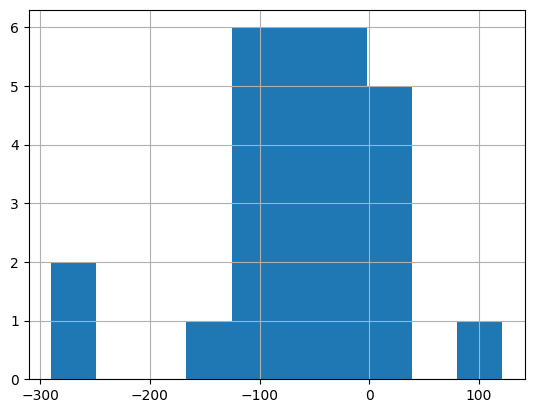

In [100]:
dist_diff_v1_df['diff'].hist()

<AxesSubplot:ylabel='Density'>

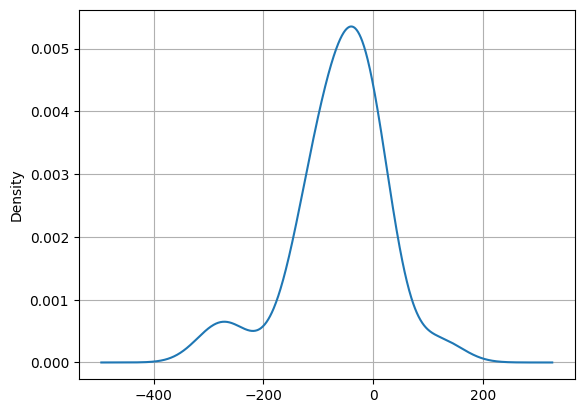

In [89]:
dist_diff_v1_df['diff'].plot.density(grid=True)

<AxesSubplot:>

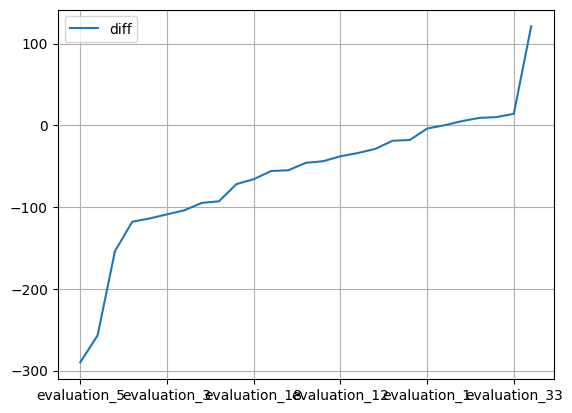

In [75]:
dist_diff_v1_df.sort_values('diff').plot(y='diff', grid=True)

### Promedio de la mejora porcentual de velocidad

In [76]:
dist_diff_v1_df['diff'].mean()

-61.333333333333336

### Cantidad de casos exitosos UTN vs Maryland

In [78]:
100*dist_diff_v1_df.loc[dist_diff_v1_df['diff']>=0].shape[0]/dist_diff_v1_df.shape[0]

22.22222222222222

In [53]:
dist_diff_v2 = {}
for evaluation in data_check.index:
    data = data_check.loc[evaluation[0]]
    total_area = bdh.worlds[evaluation[0]]['free_area']
    dist_diff_v2[evaluation[0]] = {
        'diff': 100*int(data.loc['MARYLAND']['dist_explored_80%']-data.loc['UTN_DIST']['dist_explored_80%'])/int(data.loc['MARYLAND']['dist_explored_80%']),
        'total_area': total_area
    }
dist_diff_v2_df = pd.DataFrame(dist_diff_v2).T.sort_values('total_area')

### UTN distancia vs Maryland grafico

<AxesSubplot:>

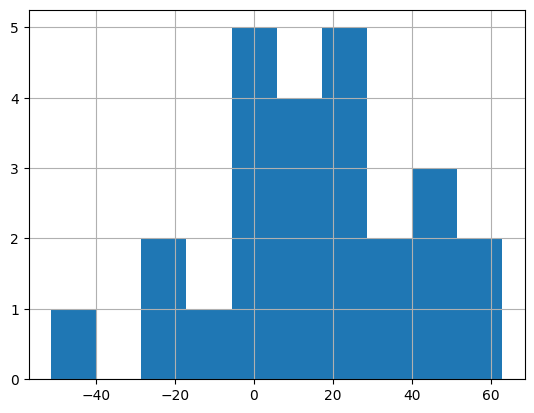

In [99]:
dist_diff_v2_df['diff'].hist()

<AxesSubplot:ylabel='Density'>

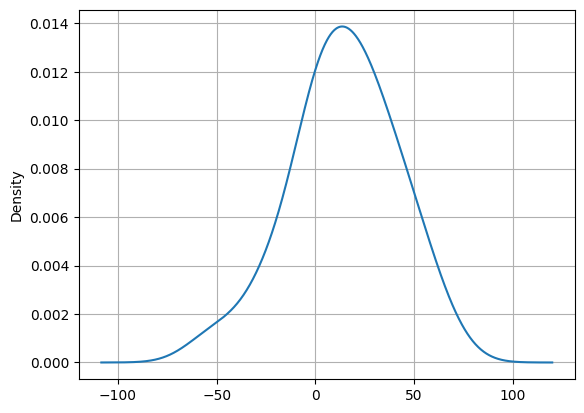

In [90]:
dist_diff_v2_df['diff'].plot.density(grid=True)

<AxesSubplot:>

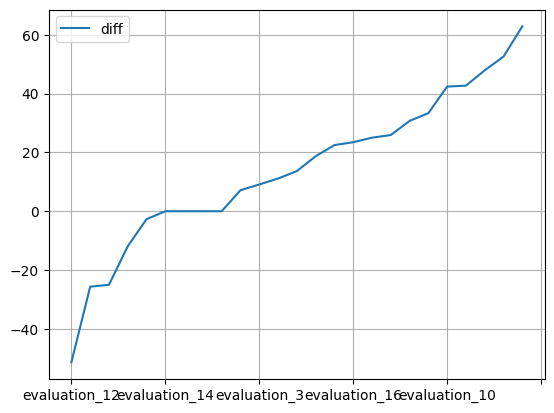

In [70]:
dist_diff_v2_df.sort_values('diff').plot(y='diff', grid=True)

### Promedio de la mejora porcentual de velocidad

In [71]:
dist_diff_v2_df['diff'].mean()

14.088324052779681

### Cantidad de casos exitosos UTN vs Maryland

In [73]:
100*dist_diff_v2_df.loc[dist_diff_v2_df['diff']>=0].shape[0]/dist_diff_v2_df.shape[0]

80.0